# Verge and foliot mechanism

References:

- https://github.com/JuliaReach/ReachabilityModels.jl/issues/52

- https://github.com/SciML/DifferentialEquations.jl/issues/703

## Dependencies

In [47]:
using ReachabilityAnalysis, LinearAlgebra, Plots, IntervalConstraintProgramming
const IA = IntervalArithmetic

LazySets.set_ztol(Float64, 1e-12)
LazySets.vertices_list(B::IntervalBox) = vertices_list(convert(Hyperrectangle, B))

## Model parameters

In [48]:
const torque = 1.0
const Ic = 10.0
const Iv = 0.15
const r_c = 1.0
const r_v = 0.3
const αc = 24.0 * pi/180
const e_r = 0.05
const nteeth = round(Int, 2pi/αc) # n
const Mv = Iv/r_v^2
const Mc = Ic/r_c^2
const Gc = Mv*(1 + e_r)/r_c/(Mv + Mc)
const Gv = Mc*(1 + e_r)/r_v/(Mv + Mc)
const αv = Gv*r_c/(1-e_r)*αc/2

p = (torque, Ic);

## Guards

In [49]:
# trigonometric constraints for each m
upper_trig(m) = @constraint $r_c*sin(x1 - ($m-1)* ($αc)) - $r_v*tan(x2 + $αv/2) == 0
lower_trig(m) = @constraint $r_c*sin(($m-1)* ($αc) - x1) - $r_v*tan(-x2 + $αv/2) == 0

# domain of x1 for each m
upper_dom_x1(m; p=0) = ((m-1-1/2)*αc .. (m-1+1/2)*αc) + (2p)*pi
lower_dom_x1(m; p=0) = ((m-1-1/2)*αc .. (m-1+1/2)*αc) + (2p-1)*pi

# combined domain of x1 and x2 for each m 
upper_dom(m; p=0) = upper_dom_x1(m, p=p) × (-1 .. 1)
lower_dom(m; p=0) = lower_dom_x1(m, p=p) × (-1 .. 1)

# constraint solver tolerance
ε = 0.05

# upper constraints
U = [pave(upper_trig(m), upper_dom(m, p=0), ε).boundary for m in 1:nteeth]
Uv = [reduce(vcat, vertices_list(B) for B in Ui) |> VPolygon |> tohrep for Ui in U]

# lower constraints
L = [pave(lower_trig(m), lower_dom(m, p=0), ε).boundary for m in 1:nteeth];
Lv = [reduce(vcat, vertices_list(B) for B in Li) |> VPolygon |> tohrep for Li in L];

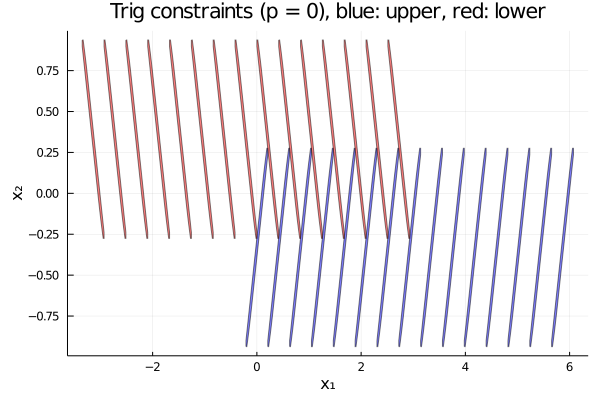

In [50]:
fig = plot(xlab="x₁", ylab="x₂", title="Trig constraints (p = 0), blue: upper, red: lower")

plot!(fig, Uv, c=:blue)
plot!(fig, Lv, c=:red)

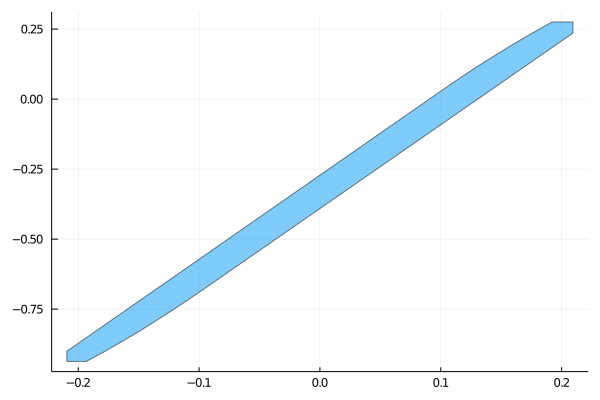

In [27]:
# overapproximate with a single set
Uv = [reduce(vcat, vertices_list(Hi) for Hi in array(Ui)) |> VPolygon |> tohrep for Ui in U]

#overapproximate()
plot(Uv[1])

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
[plot!(fig, U[i].boundary, lab="") for i in eachindex(U)]
fig

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Lower trig constraint (p = 0)")
[plot!(fig, L[i].boundary, lab="") for i in eachindex(L)]
fig

In [ ]:
G34_upper = HalfSpace([-r_c, r_v], 0.0) # r_c x3 - r_v x4 > 0
G34_lower = HalfSpace([-r_c, -r_v], 0.0); # r_c x3 + r_v x4 > 0

## Transition map

In [ ]:
# σ = 1
Fupper = zeros(5, 5)
Fupper[3, 3] = -r_c*Gc
Fupper[3, 4] = r_v*Gc
Fupper[4, 3] = r_c*Gv
Fupper[4, 4] = - r_v*Gv

# σ = -1
Flower = zeros(5, 5)
Flower[3, 3] = -r_c*Gc
Flower[3, 4] = -r_v*Gc
Flower[4, 3] = -r_c*Gv
Flower[4, 4] = - r_v*Gv;

## Continuous post-operator

In [ ]:
A = zeros(5, 5) # variables x1, x2, x3, x4 and the last variable x5 wraps the constant input term
A[1, 3] = 1.0
A[2, 4] = 1.0
A[3, 5] = 1.0

X0 = Singleton([0, 0, 0, 3.0, p[1]/p[2]])
prob = @ivp(x' = A*x, x(0) ∈ X0);

@time sol = solve(prob, tspan=(0.0, 0.5), alg=GLGM06(δ=1e-3));

In [ ]:
plot(sol, vars=(0, 1), xlab="t", ylab="x₁(t)")

In [ ]:
plot(sol, vars=(3, 4), xlab="x₃", ylab="x₄")

In [ ]:
plot(sol, vars=(1, 2), xlab="x₁(t)", ylab="x₂(t)")

In [ ]:
U[1]

In [ ]:
Uh = [convert.(Hyperrectangle, Ui.boundary) for Ui in U]

# TEMP see https://github.com/JuliaReach/LazySets.jl/issues/2447
Uh = [[Hyperrectangle(Vector(Ui[i].center), Vector(Ui[i].radius)) for i in eachindex(Ui)] for Ui in Uh];

Uz = [overapproximate(ConvexHullArray(Ui), Zonotope, OctDirections(2)) for Ui in Uh];

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
[plot!(fig, U[i].boundary, lab="") for i in eachindex(U)]
fig
plot!(Uz)

In [ ]:
@time V = [VPolygon(reduce(vcat, vertices_list.(convert.(Hyperrectangle, Ui.boundary)))) for Ui in U];

In [ ]:
Vp = [VPolygon(Vector.(Vi.vertices)) for Vi in V];
Vh = [convert(HPolygon, Vi) for Vi in Vp];

In [ ]:
plot(Vh)

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
[plot!(fig, U[i].boundary, lab="") for i in eachindex(U)]
plot!(fig, Vh)

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
[plot!(fig, U[i].boundary, lab="") for i in eachindex(U)]
plot!(fig, Vh)
plot!(fig, sol, vars=(1, 2))

In [ ]:
fig = plot()

#plot!(fig, G34_upper, lab="Upper", alpha=.1)
#plot!(fig, G34_lower, lab="Lower", xlims=(-10, 10), ylims=(-10, 10), alpha=.1)

plot!(fig, sol, vars=(1, 2), xlab="x₃", ylab="x₄", lw=5.0)

In [ ]:
LazySets.set_ztol(Float64, 1e-15)

In [ ]:
fig = plot(xlab="x₁", ylab="x₂", title="Upper trig constraint (p = 0)")
[plot!(fig, U[i].boundary, lab="") for i in eachindex(U)]
[plot!(fig, L[i].boundary, lab="") for i in eachindex(L)]
#plot!(fig, Vh)
plot!(fig, sol, vars=(1, 2))